In [ ]:
# WICHTIG: KEINE DATENAUGMENTATION in diesem code!!!!

# ====== Imports ===
import h5py
from pathlib import Path
import numpy as np
# import matplotlib.pyplot as plt

import tensorflow as tf
from jens_stuff import DatasetGenerator, SumScaleNormalizer, reset_random_seeds


# Variables
WINDOW_SIZE = 5
GROUP_LEN = 41


# ================= Function for building 3D Datasets =================

def build_sequential_dataset(low_data, high_data, size, group_len, dtype=np.float32):
    """
    Generates training data:
      X: (B, size, H, W) = window of `size` Low-Count images
      Y: (B, size, H, W) = Ground truth = window of `size` High-Count images (3D output)
      N: Number of Pictrues in total
      H: Height of each image
      W: Width of each image
      size: Size of sliding window (must be odd)
      group_len: Length of each block (41 for training/test/val)
    """
    assert low_data.shape == high_data.shape, "low/high must have identical shapes"
    N, H, W = low_data.shape
    if size % 2 == 0 or size < 1:
        raise ValueError("`size` must be odd and >= 1 (e.g., 3, 5, 7)")
    if N % group_len != 0:
        raise ValueError(f"N={N} is not a multiple of group_len={group_len}.")

    num_groups = N // group_len
    X_list, Y_list = [], []

    for group_index in range(num_groups):
        start = group_index * group_len
        end   = start + group_len
        # slide window inside this block only
        for n in range(start, end - size + 1):         # stride = 1
            X_list.append(low_data[n: n + size])       # (size,H,W)
            Y_list.append(high_data[n: n + size])      # (size,H,W)

    X = np.stack(X_list, axis=0).astype(dtype)   # (B, size, H, W)
    Y = np.stack(Y_list, axis=0).astype(dtype)   # (B, size, H, W)
    # Adding Channel-Dimension since PyTorch expects (B,C,D,H,W) with C=1
    X = X[..., None]  # (B, size, H, W, 1)
    Y = Y[..., None]  # (B, size, H, W, 1)
    return X, Y

def _load_hwN(fp):
    """
    Transposes dataset to go from matlab --> python format
    """
    with h5py.File(fp, "r") as f:
        high = f["/high_count/data"][:].transpose(2, 0, 1)  # (H,W,N) -> (N,H,W)
        low  = f["/low_count/data"][:].transpose(2, 0, 1)
    return high, low

def prepare_in_memory_5to5(
    data_dir = Path.home() / "data" / "original_data",
    size=WINDOW_SIZE,
    group_len=GROUP_LEN,
    dtype=np.float32,
):
    data = {
        "train": _load_hwN(data_dir / "training_data.hdf5"),
        "val":   _load_hwN(data_dir / "validation_data.hdf5"),
        "test":  _load_hwN(data_dir / "test_data.hdf5"),
    }
    results = {}
    for split in ["train", "val", "test"]:
        high, low = data[split]
        X, Y = build_sequential_dataset(low, high, size=size, group_len=group_len, dtype=dtype)
        results[split] = (X, Y)
    return results

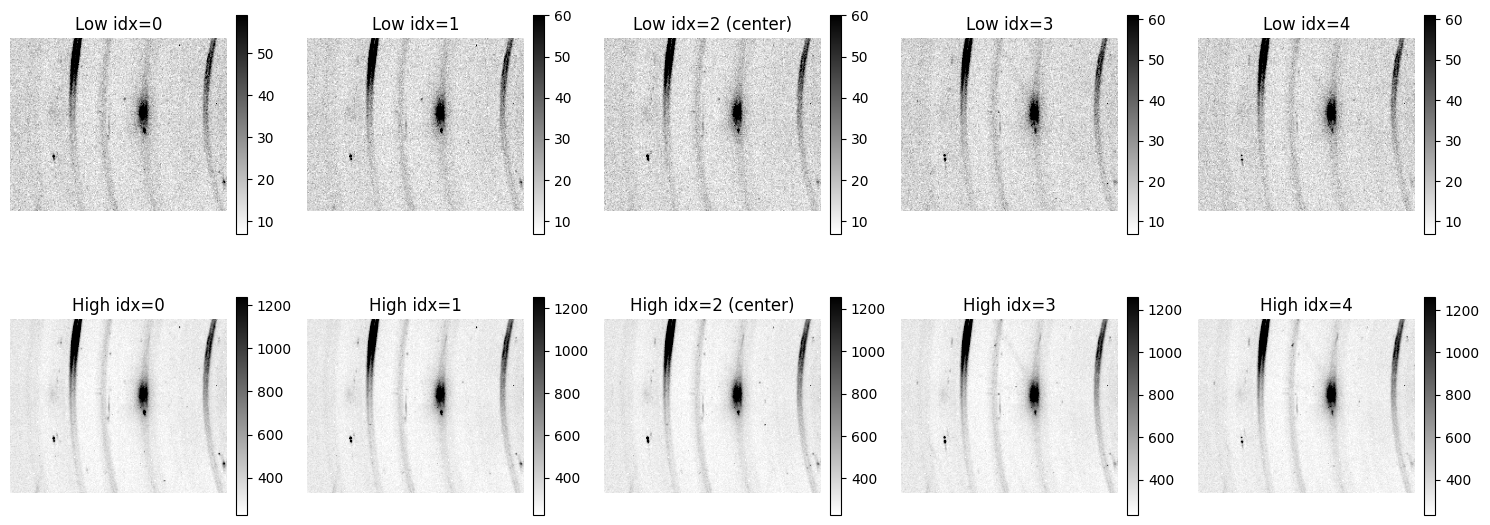

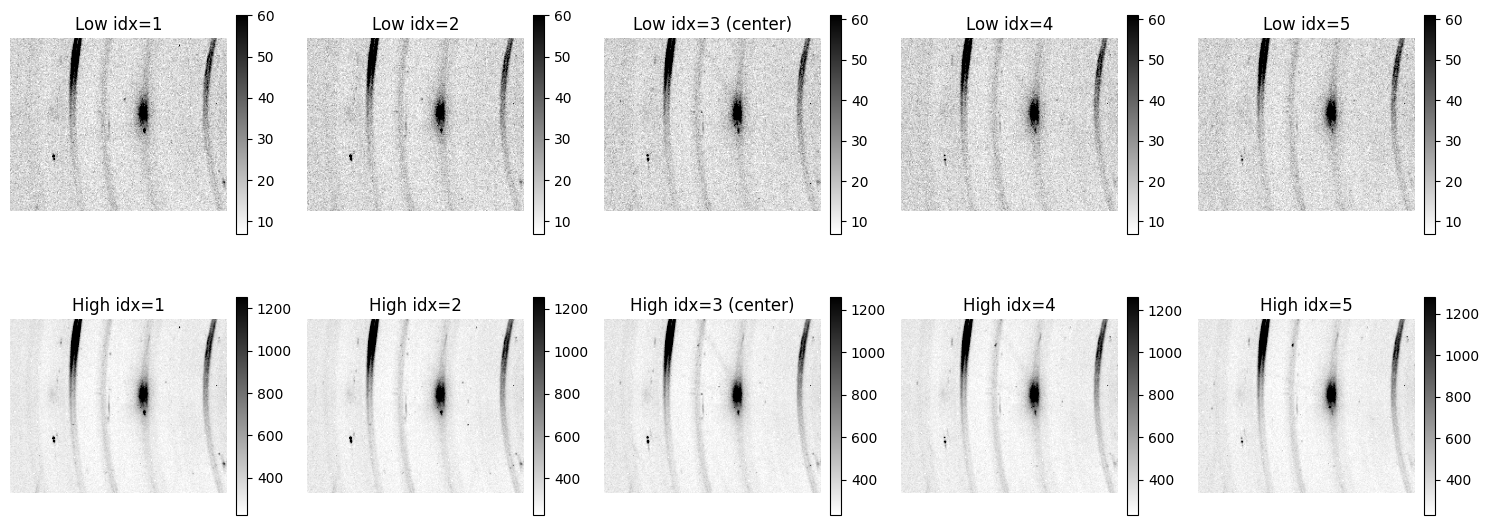

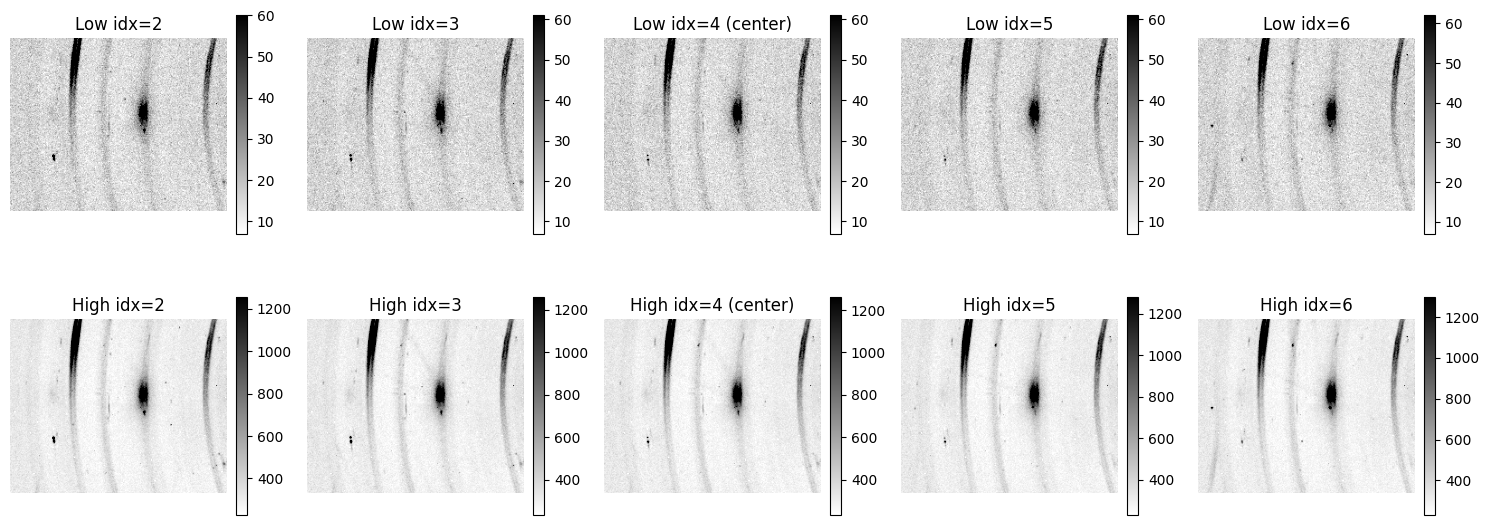

In [ ]:
# ===== Visualization of some samples =====
"""
def show_window_pair_3d(X, Y, sample_idx, size=5, group_len=41):

    seq_low  = X[sample_idx, ..., 0]   # (size,H,W)
    seq_high = Y[sample_idx, ..., 0]   # (size,H,W)

    k = size // 2
    group_idx = sample_idx // (group_len - size + 1)
    offset_in_group = sample_idx % (group_len - size + 1)
    global_start = group_idx * group_len + offset_in_group
    frame_indices = list(range(global_start, global_start + size))

    fig, axes = plt.subplots(2, size, figsize=(3 * size, 6))
    for j in range(size):
        v1, v2 = np.percentile(seq_low[j].ravel(), (1,99))
        im_low = axes[0, j].imshow(seq_low[j], cmap="gray_r", origin="lower",
                                   aspect="equal", vmin=v1, vmax=v2)
        axes[0, j].set_title(f"Low idx={frame_indices[j]}"); axes[0, j].axis("off")
        fig.colorbar(im_low, ax=axes[0, j], fraction=0.046, pad=0.04)

        v1, v2 = np.percentile(seq_high[j].ravel(), (1,99))
        im_high = axes[1, j].imshow(seq_high[j], cmap="gray_r", origin="lower",
                                    aspect="equal", vmin=v1, vmax=v2)
        axes[1, j].set_title(f"High idx={frame_indices[j]}"); axes[1, j].axis("off")
        fig.colorbar(im_high, ax=axes[1, j], fraction=0.046, pad=0.04)

    axes[0, k].set_title(f"Low idx={frame_indices[k]} (center)")
    axes[1, k].set_title(f"High idx={frame_indices[k]} (center)")
    plt.tight_layout(); plt.show()

# Visualizing examples:
X_vis, Y_vis = results["train"]
for idx in range(3):
    show_window_pair_3d(X_vis, Y_vis, sample_idx=idx, size=WINDOW_SIZE, group_len=GROUP_LEN)
"""